In [198]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as spo
import scipy.stats as sps
import copy
from bisect import bisect_left
%matplotlib inline

In [199]:
from BranchingProcess import Person, BranchingProcess, read_from_files
file_names = map(lambda name: name + ".txt", "E W T M Q L R F G P".split())
processes = read_from_files(file_names)

Отфильтруем процессы, выбирая из всех людей только тех, у кого известна фамилия, и удалив процессы, состоящие из одного человека.
Посчитаем минимальное, максимальное и среднее количество поколений в процессе

In [200]:
def modify_processes(processes):
    modified_processes = []
    for pr in processes:
        if len(pr.generations) > 1:
            modified_process = BranchingProcess()
            good_generations = []
            for generation in pr.generations:
                good_generation = []
                for person in generation:
                    surname = person.name.split('-')[0]
                    if (len(surname) > 1 and surname != 'UNKNOWN'):
                        good_generation.append(person)
                if len(good_generation) > 0:
                    good_generations.append(good_generation)
            modified_process.generations = good_generations
            if len(modified_process.generations) > 1:
                modified_processes.append(modified_process)
    return modified_processes
mod_pr = modify_processes(processes)
generations_size = [len(pr.generations) for pr in mod_pr]
min_gen_number = min(generations_size)
print('Minimum generation size: ' + str(min_gen_number))
max_gen_number = max(generations_size)
print('Maximum generation size: ' + str(max_gen_number))
mean_gen_number = np.mean(generations_size)
print('Mean generation size: ' + str(mean_gen_number))

Minimum generation size: 2
Maximum generation size: 66
Mean generation size: 3.19991620279


Посчитаем год рождения самого молодого и самого старого человека и среднюю продолжительность жизни

In [201]:
birth_years = []
known_life_time = 0
sum_life_time = 0.
for pr in mod_pr:
    for generation in pr.generations:
        for person in generation:
            birth_year = person.birthday.split('-')[0]
            death_year = person.deathdate.split('-')[0]
            if (birth_year != ''):
                birth_year = int(birth_year)
                birth_years.append(birth_year)
                if (death_year != ''):
                    death_year = int(death_year)
                    sum_life_time += death_year - birth_year
                    known_life_time += 1
print('Oldest birthdate: ' + str(min(birth_years)))
print('Youngest birthdate: ' + str(max(birth_years)))
print(sum_life_time / known_life_time)

Oldest birthdate: 1
Youngest birthdate: 2000
57.7365237675


Построим гистограммы распределения количества поколений в процессе (два, чтобы убрать хвост распределения)

Также нанесем на ось времени года рождения всех людей

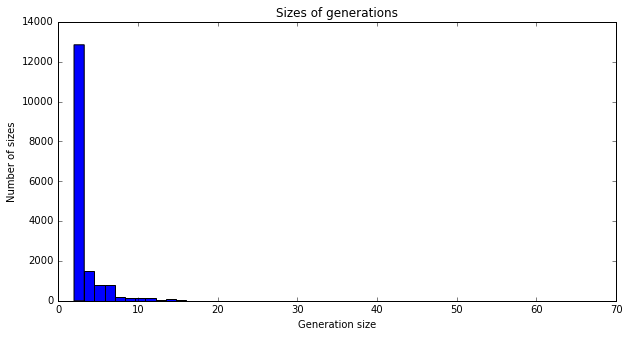

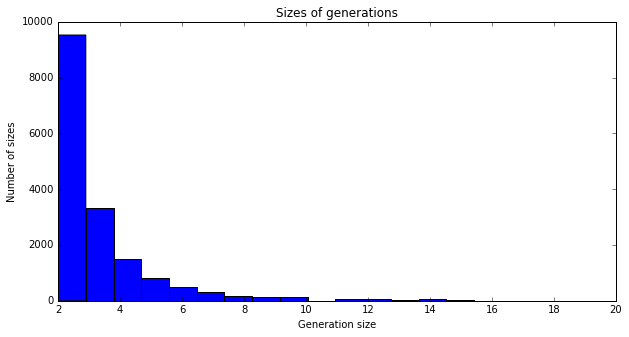

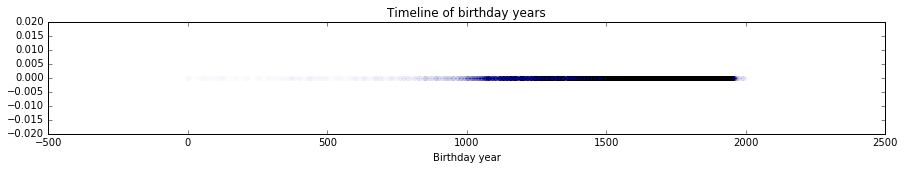

In [202]:
plt.figure(figsize=(10, 5))
plt.hist(generations_size, bins=50)
plt.xlabel('Generation size')
plt.ylabel('Number of sizes')
plt.title('Sizes of generations')
plt.show()
plt.figure(figsize=(10, 5))
plt.hist([gen_size for gen_size in generations_size if gen_size < 20], bins=19)
plt.xlabel('Generation size')
plt.ylabel('Number of sizes')
plt.title('Sizes of generations')
plt.show()
plt.figure(figsize=(15, 2))
plt.scatter(birth_years, np.zeros(len(birth_years)), alpha=0.002)
plt.title('Timeline of birthday years')
plt.xlabel('Birthday year')
plt.show()

Посчитаем статистику количества сыновей у отцов и по ней оценим параметры распределений

$$\hat{\lambda} = \overline{X}$$

$$\hat{p}_k = \frac{\sum_{i=1}^{n}{I(X_i = k)}}{n}$$

Не будем считать детей у тех отцов, чья дата рождения позже 1950 года, так как они могут ещё родить детей и тех, у кого неизвестна дата смерти, так как вероятно, что данные про них неполные и не все данные про их детей внесены в список, из-за чего оценка может получиться заниженной.

In [252]:
child_num_occurance = np.zeros(20)
poisson_mle_lambda_per_process = []
multinomial_mle_params_per_process = []
processes_for_pp_simulation = []
for pr in mod_pr:
    current_child_num_occurance = np.zeros(20)
    sum_values_per_process = 0
    sum_occurences_per_process = 0
    process_names = [person.name for generation in pr.generations \
                     for person in generation if person.gender == 'male']
    no_count_names = [person.name for person in pr.generations[-1]]
    prev_len = len(no_count_names)
    
    # не будем считать людей с г.р. больше 1950
    no_count_names += [person.name for generation in pr.generations \
                       for person in generation \
                       if person.birthday.split('-')[0] > '1950']
    
    # не будем считать людей с неизвестной датой смерти
    no_count_names += [person.name for generation in pr.generations \
                       for person in generation if person.deathdate == '']
    process_names = [name for name in process_names if name not in no_count_names]
    child_amount = dict.fromkeys(process_names, 0)
    for i in range(1, len(pr.generations)):
        for person in pr.generations[i]:
            if (person.parents[0] in process_names and person.gender == 'male'):
                child_amount[person.parents[0]] += 1
    for _, value in child_amount.items():
        child_num_occurance[value] += 1
        current_child_num_occurance[value] += 1.
        sum_occurences_per_process += 1
        sum_values_per_process += value
        
    # для того, чтобы моделировать процессы отдельно, 
    # не будем учитывать процессы, в которых два поколения, 
    # так как их трудно адекватно оценить (в них будет только один отец)
    if (sum_occurences_per_process > 0 and len(pr.generations) > 2):
        processes_for_pp_simulation.append(pr)
        cur_lambda_pp = float(sum_values_per_process) / sum_occurences_per_process
        poisson_mle_lambda_per_process.append(cur_lambda_pp)
        cur_params_pp = current_child_num_occurance / sum_occurences_per_process
        multinomial_mle_params_per_process.append(cur_params_pp)

Оценим параметр общего пуассоновского распределения и дискретного в общем случае и создадим случайные величины

In [231]:
sum_values = 0
sum_occurences = 0
observed_rv = []
mle_multinomial = np.zeros(20)
for value, occurence in enumerate(child_num_occurance):
    if (value < 20):  # не учитываем экстремальные значения
        mle_multinomial[value] = occurence
    sum_values += value * occurence
    sum_occurences += occurence
    observed_rv += [value] * occurence
poisson_mle_lambda = float(sum_values) / sum_occurences
mle_multinomial = np.array(mle_multinomial) / float(sum(mle_multinomial))
poisson_rv = sps.poisson(poisson_mle_lambda)

/Users/ocksumoron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Посчитаем критерий хи-квадрат для пуассоновского распределения

Построим гистограммы распределения Пуассона и настоящих значений

Power_divergenceResult(statistic=207571808579.55002, pvalue=0.0)


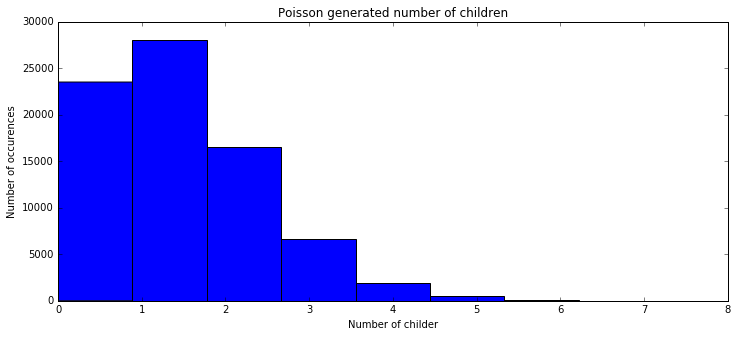

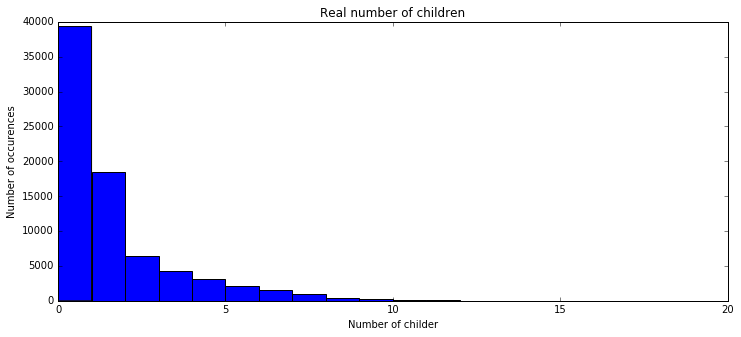

In [220]:
total_children = sum(child_num_occurance)
expected_rv = poisson_rv.rvs(len(observed_rv))
print(sps.chisquare(child_num_occurance, \
                    f_exp=[total_children * poisson_rv.pmf(x) for x in range(20)], \
                    ddof=1))
plt.figure(figsize=(12, 5))
plt.hist(expected_rv, bins=9)
plt.title('Poisson generated number of children')
plt.xlabel('Number of childer')
plt.ylabel('Number of occurences')
plt.show()
plt.figure(figsize=(12, 5))
plt.hist(observed_rv, bins=19)
plt.title('Real number of children')
plt.xlabel('Number of childer')
plt.ylabel('Number of occurences')
plt.show()

Видно, что статистика критерия хи-квадрат получилась очень большой, что означает, что наше распределение плохо приближается пуассоновским.

Посчитаем критерий хи-квадрат для мультиномиального распределения

In [236]:
exp = np.random.multinomial(sum(child_num_occurance), mle_multinomial)
print(sps.chisquare(child_num_occurance, f_exp=exp))

Power_divergenceResult(statistic=12.348069898005617, pvalue=0.87021313939362288)


Тут получили гораздо более меньшую статистику хи-квадрат. Это неудивительно, так как мы приближаем распределение "эмпирическим", которое и должно быть оптимальным с точки зрения критерия хи-квадрат.

Впрочем, в дальнейшем мы увидим, что при моделировании процессов вперед или назад, распределение Пуассона и дискретное в общем в виде ведут себя очень похоже.

Реализуем функции для работы со случайными величинами из пуассоновского распределения и дискретного в общем случае:
По параметрам и количеству возвращающие сумму значений величин, просто по количеству возвращающие сумму величин, в которых параметр - ОМП для всей выборки и функции, которые по параметру возвращают функцию, которая по количеству будет возвращать сумму значений.
Они пригодятся далее.

In [208]:
def multinomial_sum(params, n):
    result = 0
    multinomial_rvs = np.random.multinomial(n, params)
    for i, value in enumerate(multinomial_rvs):
        result += i * value
    return result

def poisson_lambda_n(lmd, n):
    return sps.poisson.rvs(n * lmd, size=1).sum()

def multinomial_mle_values(n):
    return multinomial_sum(mle_multinomial, n)

def poisson_mle_values(n):
    return poisson_rv.rvs(n).sum()

def poisson_value_generator(lmd):
    return (lambda n: sps.poisson.rvs(lmd, size=n).sum())

def multinomial_value_generator(params):
    return (lambda n: multinomial_sum(params, n))

### Моделирования процесса "назад"

Промоделируем процесс "назад", объдинив всех людей из нулевого поколения.

Будем поддерживать текущий массив людей и генерировать "отцов" для данного массива. Когда людей становится не больше нуля, начинаем генерировать "отцов" для "отцов", и так далее, пока процесс не сойдется. Генерировать будем из пуассоновского распределения и дискретного в общем случае.

При моделировании процессов "назад" мы используем параметры, оцененные по всем процессам вместе.

$simulate\_population\_backwards$ - функция для моделирования при объединении всех "родоначальников" в одно поколение.
$simulate\_n\_generations\_backwards$ - функция для моделирования при распределении "родоначальников" по дате рождения.

In [240]:
# law_of_distribution - закон, по которому будет проходить моделирование
# last_generation - количество людей в первом известном поколении
def simulate_population_backwards(last_generation, law_of_distribution):
    simulated_population = [last_generation]
    current_population = last_generation
    prev_population = 0
    while (True):
        simulated_father = law_of_distribution(1)
        prev_population += 1
        current_population -= simulated_father
        if (current_population < 0):
            current_population = prev_population
            prev_population = 0
            simulated_population.append(current_population)
            # если людей стало слишком мало или слишком много, прекращаем моделирование
            if (current_population < 5 or \
                current_population > 1.5 * last_generation):
                break
    return simulated_population

# population_per_generation - массив, 
# в котором люди из первого известного поколения распределены по поколениям
def simulate_n_generations_backwards(population_per_generation, \
                                     law_of_distribution):
    simulated_population = []
    simulated_population_tmp = copy.deepcopy(population_per_generation)
    for i in range(len(population_per_generation) - 1):
        simulated_population.append(simulated_population_tmp[i])
        while (simulated_population_tmp[i] > 0):
            simulated_father = law_of_distribution(1)
            simulated_population_tmp[i] -= simulated_father
            simulated_population_tmp[i + 1] += 1
    simulated_population.append(simulated_population_tmp[-1])
    return simulated_population

Построим графики для промоделированного процесса, не опирающегося на данные о дате рождения

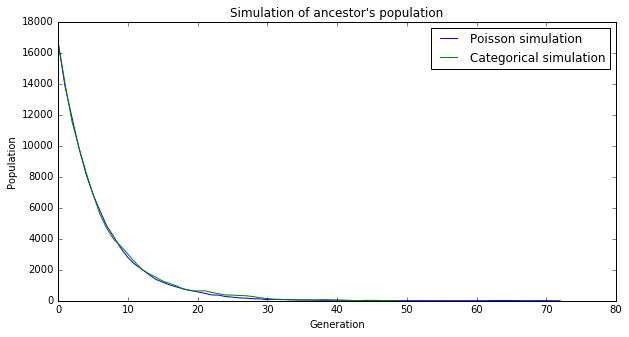

In [241]:
plt.figure(figsize=(10, 5))
plt.plot(simulate_population_backwards(len(mod_pr), poisson_mle_values), \
         label='Poisson simulation')
plt.plot(simulate_population_backwards(len(mod_pr), multinomial_mle_values), \
         label='Categorical simulation')
plt.xlabel('Generation')
plt.ylabel('Population')
plt.title('Simulation of ancestor\'s population')
plt.legend()
plt.show()

На этом графике видно, что распределение Пуассона и дискретное в общем случае выглядят очень похоже, и что оба процесса сходятся к одному предку.

Напишем функцию, которая по году будет возвращать индекс в массиве поколений по формуле
$$index = -\frac{year - 2000}{25}$$

То есть мы условно разбиваем время на поколения по 25 лет.

In [242]:
def year_to_index(year):
    return -((year - 2000) / 25)
generation = np.zeros(100)

for pr in mod_pr:
    year = pr.generations[0][0].birthday.split('-')[0]
    if (year != ''):
        index = year_to_index(int(year))
        generation[index] += 1

Построим графики для промоделированных процессов с учетом даты рождения.

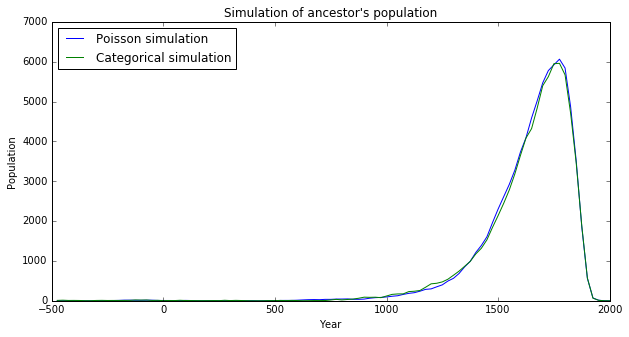

In [243]:
plt.figure(figsize=(10, 5))
plt.plot(map(lambda x: -x * 25 + 2000, range(0, 100)), \
         simulate_n_generations_backwards(generation, poisson_mle_values), \
         label='Poisson simulation')
plt.plot(map(lambda x: -x * 25 + 2000, range(0, 100)), \
         simulate_n_generations_backwards(generation, multinomial_mle_values), \
         label='Categorical simulation')
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Simulation of ancestor\'s population')
plt.legend(loc='upper left')
plt.show()

На графике виден пик в районе 1700 года - это объясняется тем, что в данных большинство "родоначальников" родились как раз в это время.

Так же видно, что процесс сходится к одному человеку

### Моделирование процесса "вперед"

Тут мы сразу будем разделять людей на поколения по 25 лет по формуле

$$ index = \frac{year - 1800}{25} $$

И реализуем функцию, которая будет моделировать процесс на n поколений вперед и возвращать массив с количеством фамилий и количеством людей по поколениям.

In [253]:
def year_to_index2(year):
    if (year < 1800):
        return 0
    return (year - 1800) / 25

# n_generations - количество поколений, которое будет моделироваться
# generation - последнее поколение, с которого будет начинаться моделирование
# law_of_distribution - закон разспределения, по которому будут моделироваться дети
# params - параметр закона распределения
def simulate_n_generations_forward(n_generations, \
                                   generation, \
                                   law_of_distribution, \
                                   params):
    
    simulated_male_population = np.zeros(n_generations)
    
    # добавим людей из последнего поколения
    for person in generation:
        if (person.gender == 'male' and person.birthday.split('-')[0] != ''):
            index = year_to_index2(int(person.birthday.split('-')[0]))
            simulated_male_population[index] += 1
            
    # моделируем процесс "вперед"            
    for i in range(len(simulated_male_population) - 1):
        simulated_male_population[i + 1] += \
            law_of_distribution(params, simulated_male_population[i])
    
    simulated_surnames_amount = np.zeros(n_generations)
    
    # заполняем массив с фамилиями
    for i in range(len(simulated_male_population)):
        if (simulated_male_population[i] > 0):
            simulated_surnames_amount[i] = 1
            
    return simulated_surnames_amount, simulated_male_population

Теперь с помощью написанной функции посчитаем массивы с фамилиями и населением для пуассоновского распределения и дискретного в общем случае, с оцененными параметрами для всех процессов вместе и для каждого отдельно.

In [254]:
n_gen = 20
total_surnames_amount_mle_poisson = np.zeros(n_gen)
total_surnames_amount_mle_multinomial = np.zeros(n_gen)

total_male_population_mle_poisson = np.zeros(n_gen)
total_male_population_mle_multinomial = np.zeros(n_gen)

total_surnames_amount_pp_poisson = np.zeros(n_gen)
total_surnames_amount_pp_multinomial = np.zeros(n_gen)

total_male_population_pp_poisson = np.zeros(n_gen)
total_male_population_pp_multinomial = np.zeros(n_gen)

for i, pr in enumerate(processes_for_pp_simulation):
    
    current_lambda = poisson_mle_lambda_per_process[i]
    current_multinomial_params = multinomial_mle_params_per_process[i]
    
    current_pr_surname_amount_mle_poisson, current_pr_male_population_mle_poisson = \
        simulate_n_generations_forward(n_gen, pr.generations[-1], \
                                       poisson_lambda_n, poisson_mle_lambda)
    
    current_pr_surname_amount_mle_multinomial, current_pr_male_population_mle_multinomial = \
        simulate_n_generations_forward(n_gen, pr.generations[-1], \
                                       multinomial_sum, mle_multinomial)
        
    total_surnames_amount_mle_poisson += current_pr_surname_amount_mle_poisson
    total_surnames_amount_mle_multinomial += current_pr_surname_amount_mle_multinomial
    
    total_male_population_mle_poisson += current_pr_male_population_mle_poisson
    total_male_population_mle_multinomial += current_pr_male_population_mle_multinomial
    
    current_pr_surname_amount_pp_poisson, current_pr_male_population_pp_poisson = \
        simulate_n_generations_forward(n_gen, pr.generations[-1], \
                                       poisson_lambda_n, current_lambda)

    total_surnames_amount_pp_poisson += current_pr_surname_amount_pp_poisson
    total_male_population_pp_poisson += current_pr_male_population_pp_poisson
        
    current_pr_surname_amount_pp_multinomial, current_pr_male_population_pp_multinomial = \
        simulate_n_generations_forward(n_gen, pr.generations[-1], \
                                       multinomial_sum, current_multinomial_params)
    
    total_surnames_amount_pp_multinomial += current_pr_surname_amount_pp_multinomial
    total_male_population_pp_multinomial += current_pr_male_population_pp_multinomial

Построим сразу все графики и будем откладывать на одном графике обе зависимости

Total number of surnames: 6330


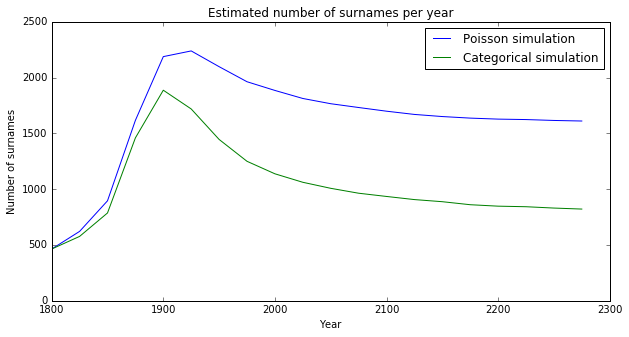

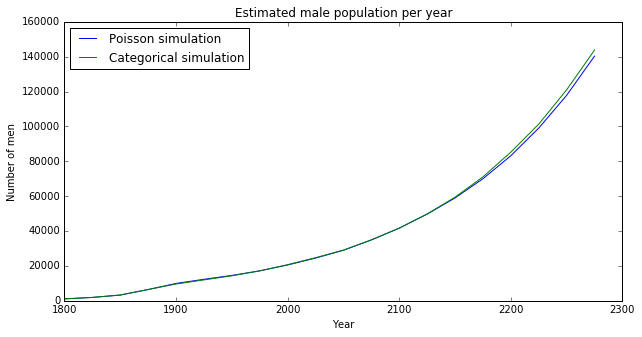

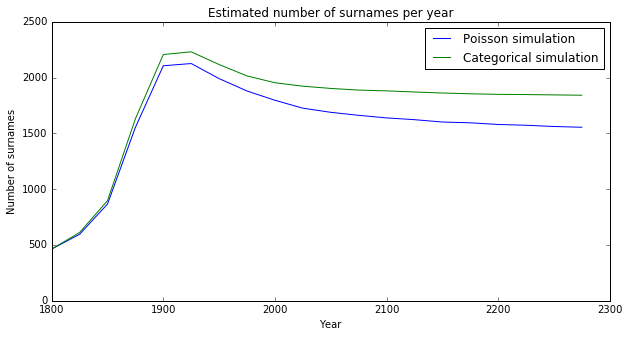

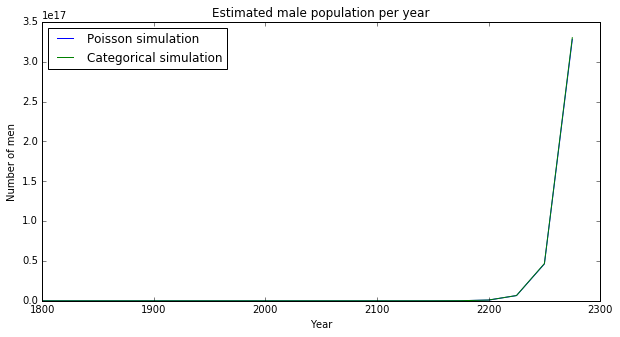

In [255]:
print('Total number of surnames: ' + str(len(processes_for_pp_simulation)))

plt.figure(figsize=(10, 5))
plt.plot(map(lambda x: x * 25 + 1800, range(0, n_gen)), \
         total_surnames_amount_mle_poisson, label='Poisson simulation')
plt.plot(map(lambda x: x * 25 + 1800, range(0, n_gen)), \
         total_surnames_amount_mle_multinomial, label='Categorical simulation')
plt.xlabel('Year')
plt.ylabel('Number of surnames')
plt.title('Estimated number of surnames per year')
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(map(lambda x: x * 25 + 1800, range(0, n_gen)), \
         total_male_population_mle_poisson, label='Poisson simulation')
plt.plot(map(lambda x: x * 25 + 1800, range(0, n_gen)), \
         total_male_population_mle_multinomial, label='Categorical simulation')
plt.xlabel('Year')
plt.ylabel('Number of men')
plt.title('Estimated male population per year')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(map(lambda x: x * 25 + 1800, range(0, n_gen)), \
         total_surnames_amount_pp_poisson, label='Poisson simulation')
plt.plot(map(lambda x: x * 25 + 1800, range(0, n_gen)), \
         total_surnames_amount_pp_multinomial, label='Categorical simulation')
plt.xlabel('Year')
plt.ylabel('Number of surnames')
plt.title('Estimated number of surnames per year')
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(map(lambda x: x * 25 + 1800, range(0, n_gen)), \
         total_male_population_pp_poisson, label='Poisson simulation')
plt.plot(map(lambda x: x * 25 + 1800, range(0, n_gen)), \
         total_male_population_pp_multinomial, label='Categorical simulation')
plt.xlabel('Year')
plt.ylabel('Number of men')
plt.title('Estimated male population per year')
plt.legend(loc='upper left')
plt.show()

Проанализируем графики количества фамилий:

При обоих способах моделирования количество фамилий сначала увеличивается - это легко объяснить тем, что в 1800-2000 "добавляются" новые родословные.

Затем происходит небольшой спад - это вымирают некоторые процессы.

И затем график стабилизируется, что говорит о том, что оставшиеся к этому времени процессы уже с большой вероятностью не вымирают и размножаются дальше.

Теперь по графикам общей численности мужского населения:

Видно, что когда мы моделируем общим параметром для всех процессов, то общее население растет не очень быстро, но тем не менее экспоненциально

В случае, когда у каждого процесса свой параметр, мы видим очень резкое увеличение населения в последнии 100 лет.

Это можно объяснить тем, что есть небольшие процессы, в которых есть очень много детей-мальчиков, и именно эти семьи через 50-100 лет начинают очень резко увеличиваться в размере

Реализуем производящие функции для распределения Пуассона. Найдем минимальный корень уравнения
$$ q = \phi_{\xi}(q)$$

для всех процессов вместе и для каждого в отдельности.

Как известно, производящая функция для пуассоновского распределения имеет явный вид:

$$\phi_{\xi}(z) = e^{\lambda(z - 1)}$$

Чтобы найти корень изначального уравнения, будем минимизировать функцию

$$f(q) = (\phi_{\xi}(q) - q)^2 $$

Probability of extinction based on every process: 0.69937566137
Ratio of processes with probability of extinction below 0.5 to number of processes: 0.249763033175


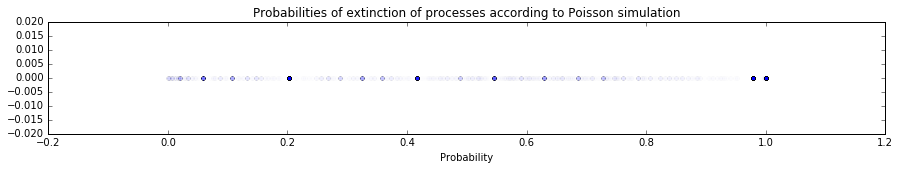

In [216]:
def poisson_generation_function(l, z):
    return np.exp(l * (z - 1))

def f1(lmd):
    return (lambda q: (poisson_generation_function(lmd, q) - q) ** 2)

q0 = spo.minimize(f1(poisson_mle_lambda), 0).x
print('Probability of extinction based on every process: ' + str(q0[0]))

probs = [spo.minimize(f1(lmd), 0).x for lmd in poisson_mle_lambda_per_process]
probs_05 = [x for x in probs if x < 0.5]
print('Ratio of processes with probability of extinction below 0.5 to number of processes: ' + \
      str(float(len(probs_05)) / len(probs)))

plt.figure(figsize=(15, 2))
plt.scatter(probs, np.zeros(len(probs)), alpha=0.002)
plt.title('Probabilities of extinction of processes according to Poisson simulation')
plt.xlabel('Probability')
plt.show()

В случае дискретного распределения в общем виде практически ничего не меняется, кроме того, что производящую функцию можно вычислить, как сумму конечного ряда:

$$\phi_{\xi}(z) = \sum_{i = 0}^{N}z^i P(\xi = i)$$

Probability of extinction based on every process: 0.875346329649
Ratio of processes with probability of extinction below 0.5 to number of processes: 0.353396524487


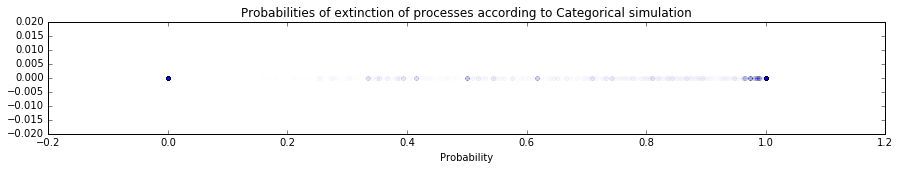

In [218]:
def multinomial_generating_function(params, z):
    result = params[0]
    for i in range(1, len(params)):
        result += z**i * params[i]
    return result

def f2(params):
    return (lambda q: (multinomial_generating_function(params, q) - q) ** 2)

q0 = spo.minimize(f2(mle_multinomial), 0., bounds=[(0., 1.)], method='L-BFGS-B').x
print('Probability of extinction based on every process: ' + str(q0[0]))

probs2 = [spo.minimize(f2(params), 0., bounds=[(0., 1.)], method='L-BFGS-B').x \
          for params in multinomial_mle_params_per_process]
probs2_05 = [x for x in probs2 if x < 0.5]
print('Ratio of processes with probability of extinction below 0.5 to number of processes: ' + \
      str(float(len(probs2_05)) / len(probs2)))

plt.figure(figsize=(15, 2))
plt.scatter(probs2, np.zeros(len(probs2)), alpha=0.002)
plt.title('Probabilities of extinction of processes according to Categorical simulation')
plt.xlabel('Probability')
plt.show()

# Выводы

Для начала проанализируем данные с вероятностями вырождения.
Мы видим, что вероятность вырождения у общего распределения Пуассона выше, чем у дискретного в общем случае. Это можно даже проследить на графике с количеством фамилий по данным, промоделированным с общим параметром: там по распределению Пуассона остается около 1600 фамилий, а по дискретному - 800, что в два раза меньше.

Так же довольно непонятно, что при таких больших вероятностях вырождения процессы тем не менее размножаются. Это можно легко объяснить тем, что вероятность считается исходя из одного "родоначальника", а в наших данных может быть довольно много людей в последнем поколении.

Ещё мы получили, что графики населений по обоим распределениям очень похожи, что говорит о том, что всё-таки пуассоновским распределением можно довольно хорошо проанализировать данные процессы, что было неочевидно из критерия хи-квадрат.

Пройдемся ещё раз по полученным результатам:

Во-первых, мы получили, что при генерации "назад" процесс сошелся к одному человеку с обоими распределениями. Это довольно логично, и вообще должно следовать из того, что матожидание у обоих распределений получилось больше 1.

Во-вторых, при генерации "вперед", процессы начинают размножаться по экспоненциальному закому. Мы при обоих генерациях не учитываем довольно много факторов, таких как средняя продолжительность жизни людей в зависимости от года проживания (и даже от места проживания), зависимость количества детей от года проживания (и опять же места проживания), какие-то глобальные катастрофы и многое другое. Тем не менее, результаты довольно показательные, и их можно использовать не только при оценке количества людей, но и количества других животных или бактерий.

И возвращаясь к основной теме исследования, ради которого собирались данные о родословных - о вырождении фамилий - мы получили, что большинство фамилий вырождаются (порядка 75%), и оставшиеся уже размножаются.

Ещё довольно противоречивы получившиеся результаты о том, что количество родословных, у которых вероятность вырождения < 0.5 меньше у распределения Пуассона, хотя на графике количество фамилий при стабилизации у него меньше. Это можно объяснить тем, что опять же вероятность считается для процесса состоящего изначально из одного человека.